<a href="https://colab.research.google.com/github/nataliachmurak/colourisation/blob/main/NCD_GAN_CIELAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Conv2D, Conv2DTranspose
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.datasets.cifar10 import load_data
from keras.datasets import cifar10
from keras.layers import UpSampling2D, InputLayer
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from tensorflow import keras



#colour schemes
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.color import rgb2gray
from skimage.io import imsave, imread
from skimage import io
from skimage.transform import resize


#others
import numpy as np
import os
import random
import tensorflow as tf
import cv2
import math
import matplotlib.pyplot as plt
import sys


In [ ]:
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt


# The batch size we'll use for training
batch_size = 64

# Size of the image required to train our model
img_size = 128

# These many images will be used from the data archive
dataset_split = 2000

master_dir = "drive/MyDrive/NCD"


x = []
y = []
groundTruth = []
for image_file in os.listdir( master_dir )[ 0 : dataset_split ]:
    rgb_image = Image.open( os.path.join( master_dir , image_file ) ).resize( ( img_size , img_size ) )
    rgb_img_array = (np.asarray( rgb_image ) ) 
    image = rgb_img_array
    Y = rgb2lab(1.0/255 * image)[:,:,1:]
    Y = Y / 128
    X = rgb2lab(1.0/255 * image)[:,:,0]
    X = np.expand_dims(X, 2)
    x.append(X)
    y.append(Y)
    
    

print(X.shape)
print(Y.shape)    


# Train-test splitting
train_x, test_x, train_y, test_y = train_test_split( np.array(x) , np.array(y) , test_size=0.1 )
print(train_x.shape)
print(test_x.shape)

# Construct tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices( ( train_x , train_y ) )
dataset = dataset.batch( batch_size )



(128, 128, 1)
(128, 128, 2)
(648, 128, 128, 1)
(73, 128, 128, 1)


In [ ]:
def get_generator_model():
  layers = [
      tf.keras.layers.InputLayer(input_shape=(128, 128, 1)),
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.UpSampling2D((2, 2)),
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.UpSampling2D((2, 2)),
      tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.UpSampling2D((2, 2)),
      tf.keras.layers.Conv2D(2, (3, 3), activation='tanh', padding='same') ]
    
  model = tf.keras.models.Sequential( layers ) 
  print(model.summary())
  return model

In [ ]:
def get_discriminator_model():
    layers = [
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7 , 7 ) , strides=1 , activation='relu' , input_shape=( 128 , 128 , 2 ) ),
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7, 7 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense( 512, activation='relu'  )  ,
        tf.keras.layers.Dense( 128 , activation='relu' ) ,
        tf.keras.layers.Dense( 16 , activation='relu' ) ,
        tf.keras.layers.Dense( 1 , activation='sigmoid' ) 
    ]
    model = tf.keras.models.Sequential( layers )
    return model

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - tf.random.uniform( shape=real_output.shape , maxval=0.1 ) , real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform( shape=fake_output.shape , maxval=0.1  ) , fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output , real_y):
    real_y = tf.cast( real_y , 'float32' )
    return mse( fake_output , real_y )

generator_optimizer = tf.keras.optimizers.Adam( 0.0005 )
discriminator_optimizer = tf.keras.optimizers.Adam( 0.0005 )

generator = get_generator_model()
discriminator = get_discriminator_model()

In [ ]:

def train_step( input_x , real_y ):
   
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate an image -> G( x )
        generated_images = generator( input_x , training=True)
        # Probability that the given image is real -> D( x )
        real_output = discriminator( real_y, training=True)
        # Probability that the given image is the one generated -> D( G( x ) )
        generated_output = discriminator(generated_images, training=True)
        
        # L2 Loss -> || y - G(x) ||^2
        gen_loss = generator_loss( generated_images , real_y )
        # Log loss for the discriminator
        disc_loss = discriminator_loss( real_output, generated_output )
    
    #tf.keras.backend.print_tensor( tf.keras.backend.mean( gen_loss ) )
    #tf.keras.backend.print_tensor( gen_loss + disc_loss )

    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimize with Adam
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [ ]:
num_epochs = 100

for e in range( num_epochs ):
    print( e )
    for ( x , y ) in dataset:
        # Here ( x , y ) represents a batch from our training dataset.
        print( x.shape )
        train_step( x , y )

In [ ]:
import matplotlib.pyplot as plt

y = generator( test_x[ 0 : 72 ] ).numpy()
y = y * 128

plt.figure(figsize=(30, 30))
for i in range(72):
  name = str(i)
  cur = np.zeros((128, 128, 3))
  cur[:,:,0] = test_x[i][:,:,0]
  cur[:,:,1:] = y[i]
  final = lab2rgb(cur)
  plt.subplot(8, 9, i+1)
  plt.imshow( final )
  imsave(name + "_color.jpg", final)
plt.show()





In [ ]:
plt.figure(figsize=(30, 30))
for i in range(72):
  name = str(i)
  cur = np.zeros((128, 128, 3))
  cur[:,:,0] = test_x[i][:,:,0]
  bw = lab2rgb(cur)
  plt.subplot(8, 9, i+1)
  plt.imshow(bw)
  imsave(name + "_bw.jpg", bw)
plt.show()   

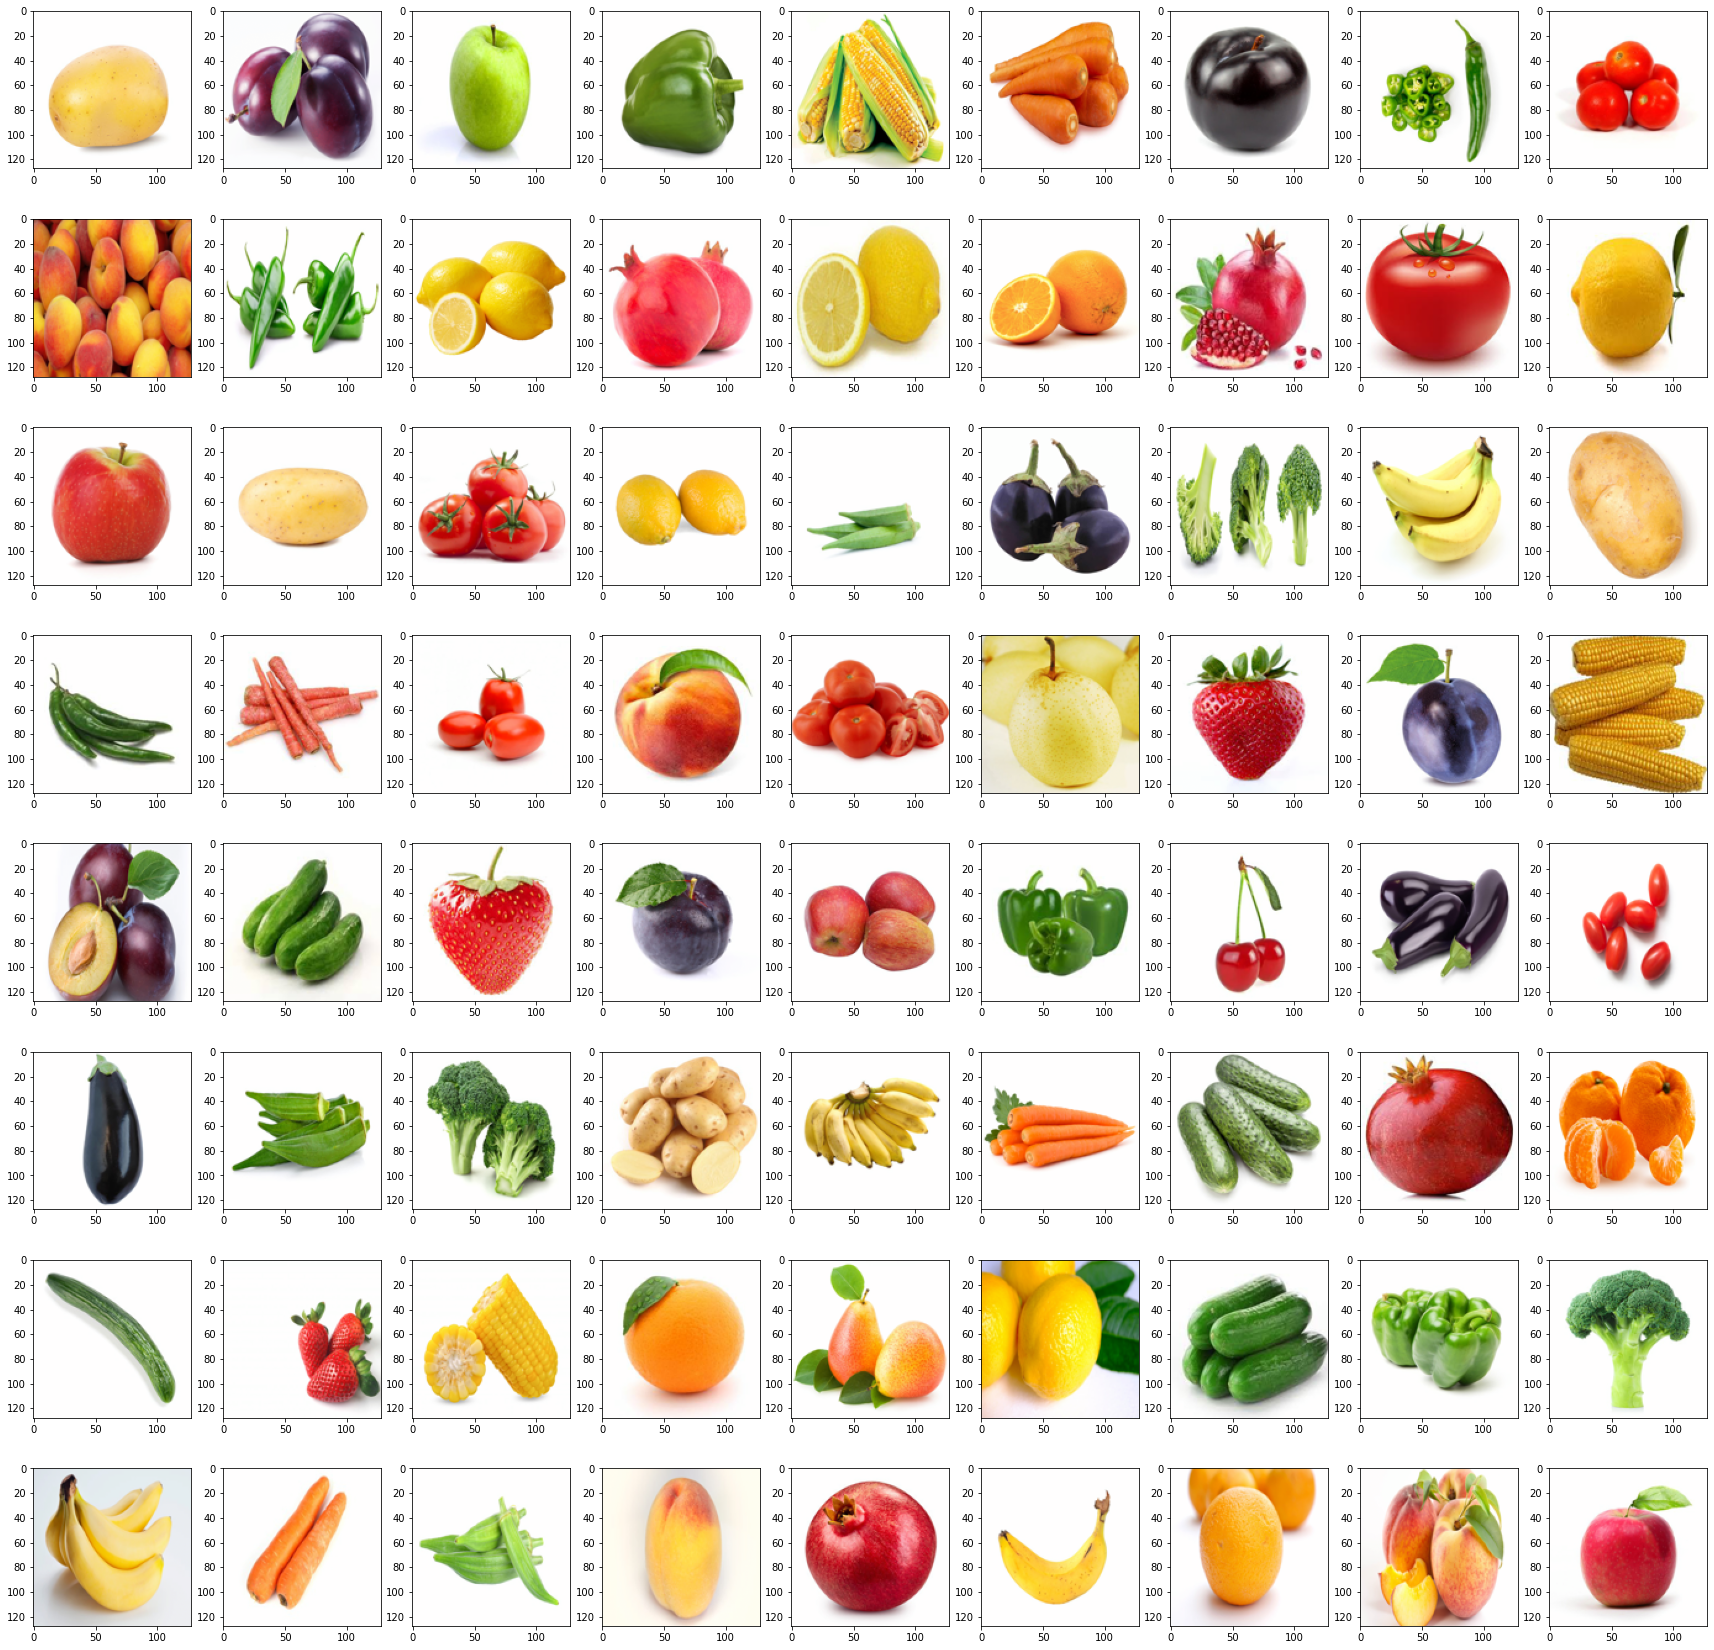

In [ ]:
test_y = test_y * 128
plt.figure(figsize=(30, 30))
for i in range(72):
  name = str(i)
  cur = np.zeros((128, 128, 3))
  cur[:,:,0] = test_x[i][:,:,0]
  cur[:,:,1:] = test_y[i]
  original = lab2rgb(cur)
  plt.subplot(8, 9, i+1)
  plt.imshow(original)
  imsave(name + "_original.jpg", original)
plt.show()  